Import required modules

In [4]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import mean_squared_error, r2_score

Load required data

In [ ]:
data = pd.read_csv('Boston.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)  # Drop index column if present
print(data.head())

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Check data about and preprocess

In [7]:
print("Data shape:", data.shape)
print("Data columns:\n", data.columns)

X = data.drop(columns=['medv'])
y = data['medv']

Data shape: (506, 14)
Data columns:
 Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')


Split data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (404, 13)
Test set size: (102, 13)


### Fully Grown Tree

In [9]:
regtree = DecisionTreeRegressor(random_state=0)
regtree.fit(X_train, y_train)

print("MSE========================")
print("Training MSE:", mean_squared_error(y_train, regtree.predict(X_train)))
print("Test MSE:", mean_squared_error(y_test, regtree.predict(X_test)))

print("\nR2========================")
print("Training R2:", r2_score(y_train, regtree.predict(X_train)))
print("Test R2:", r2_score(y_test, regtree.predict(X_test)))

print('\nTree depth:', regtree.tree_.max_depth)
print('Tree node count:', regtree.tree_.node_count)

MSE========================
Training MSE: 0.0
Test MSE: 32.41637254901961

R2========================
Training R2: 1.0
Test R2: 0.6019035496385025

Tree depth: 20
Tree node count: 765


Plot tree (Optional)

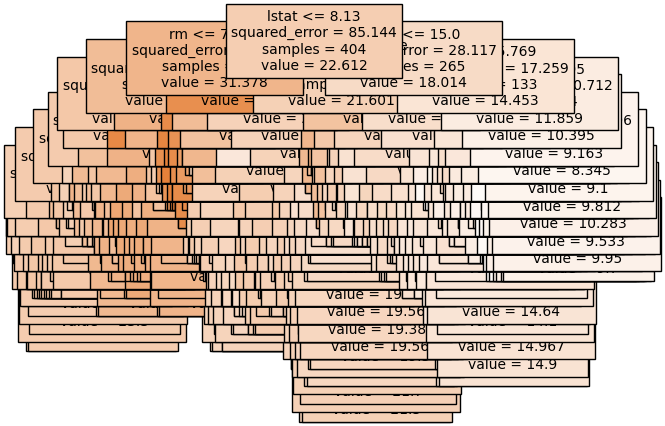

In [11]:
plt.Figure(figsize=(20, 10))
plot_tree(regtree, feature_names=data.columns, filled=True, fontsize=10)
plt.show()

Cost complexicity prunning

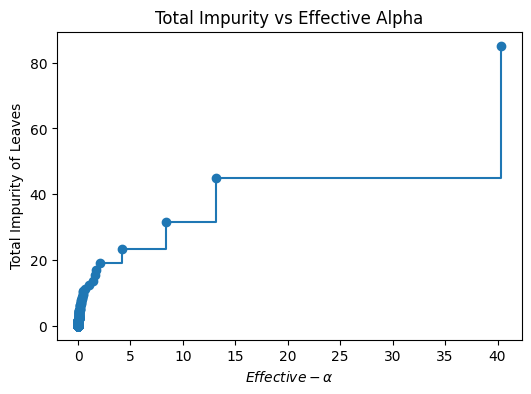

In [12]:
path = regtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.figure(figsize=(6, 4))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
plt.xlabel(r'$Effective-\alpha$')
plt.ylabel('Total Impurity of Leaves')
plt.title('Total Impurity vs Effective Alpha')
plt.show()

In [13]:
# Remove the last tree (only root), not useful for accuracy
ccp_alphas = np.unique(ccp_alphas)[:-1]
print("Total number of unique alpha values: ",len(ccp_alphas))

cv_mse = []
cv_r2 = []

for alpha in ccp_alphas:
   regtree = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
   scores = cross_validate(regtree, X_train, y_train,\
                           cv = KFold(5, shuffle=True, random_state=0),\
                              scoring=['neg_mean_squared_error', 'r2'],\
                                 n_jobs=None)
   cv_mse.append(-np.mean(scores['test_neg_mean_squared_error']))
   cv_r2.append(np.mean(scores['test_r2']))

Total number of unique alpha values:  346


In [14]:
# Choose best alpha
best_alpha_mse = ccp_alphas[np.argmin(cv_mse)]
print("Best alpha:", best_alpha_mse)
print("Minimum CV_MSE:", np.min(cv_mse))

best_alpha_r2 = ccp_alphas[np.argmax(cv_r2)]
print("\nBest alpha:", best_alpha_r2)
print("Maximum R2:", np.max(cv_r2))

if best_alpha_mse == best_alpha_r2:
    print("\nBest alpha for MSE and R2 is the same:", best_alpha_mse)
    best_alpha = best_alpha_mse
else:
    print("\nBest alpha for MSE and R2 is different. Choose the one that fits your needs.")

Best alpha: 0.2816648522367009
Minimum CV_MSE: 16.469848261986094

Best alpha: 0.2816648522367009
Maximum R2: 0.804677392317141

Best alpha for MSE and R2 is the same: 0.2816648522367009


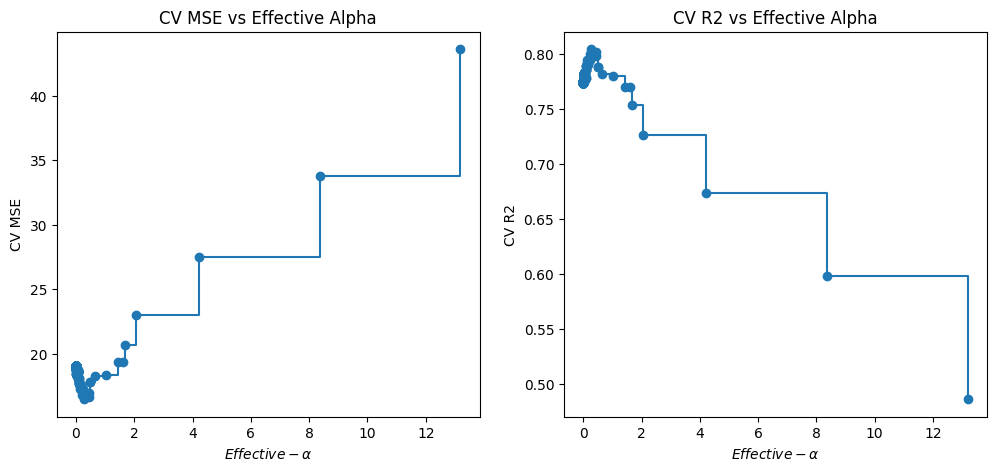

In [15]:
figure, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(ccp_alphas, cv_mse, marker='o', drawstyle='steps-post')
ax[0].set_xlabel(r'$Effective-\alpha$')
ax[0].set_ylabel('CV MSE')
ax[0].set_title('CV MSE vs Effective Alpha')

ax[1].plot(ccp_alphas, cv_r2, marker='o', drawstyle='steps-post')
ax[1].set_xlabel(r'$Effective-\alpha$')
ax[1].set_ylabel('CV R2')
ax[1].set_title('CV R2 vs Effective Alpha')
plt.show()

### Pruned tree

Pruned Tree ========================

Training MSE: 7.690398861865073
Test MSE: 31.463448265478487

Training R2: 0.9096774390210188
Test R2: 0.6136061475824068

Tree depth: 6
Tree node count: 35


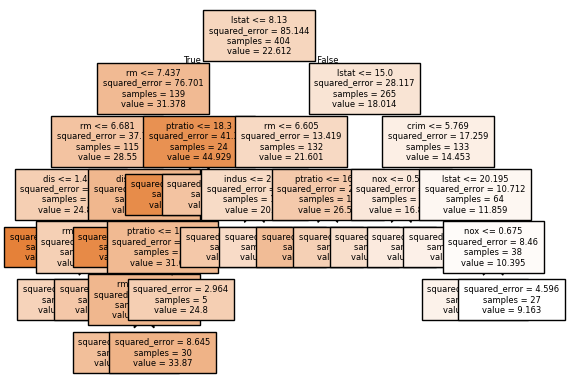

In [24]:
pruned_tree = DecisionTreeRegressor(random_state=0, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

print("Pruned Tree ========================")
print("\nTraining MSE:", mean_squared_error(y_train, pruned_tree.predict(X_train)))
print("Test MSE:", mean_squared_error(y_test, pruned_tree.predict(X_test)))
print("\nTraining R2:", r2_score(y_train, pruned_tree.predict(X_train)))
print("Test R2:", r2_score(y_test, pruned_tree.predict(X_test)))
print('\nTree depth:', pruned_tree.tree_.max_depth)
print('Tree node count:', pruned_tree.tree_.node_count)

plt.Figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=data.columns, filled=True, fontsize=6)
plt.show()

Nodes and depth vs alpha

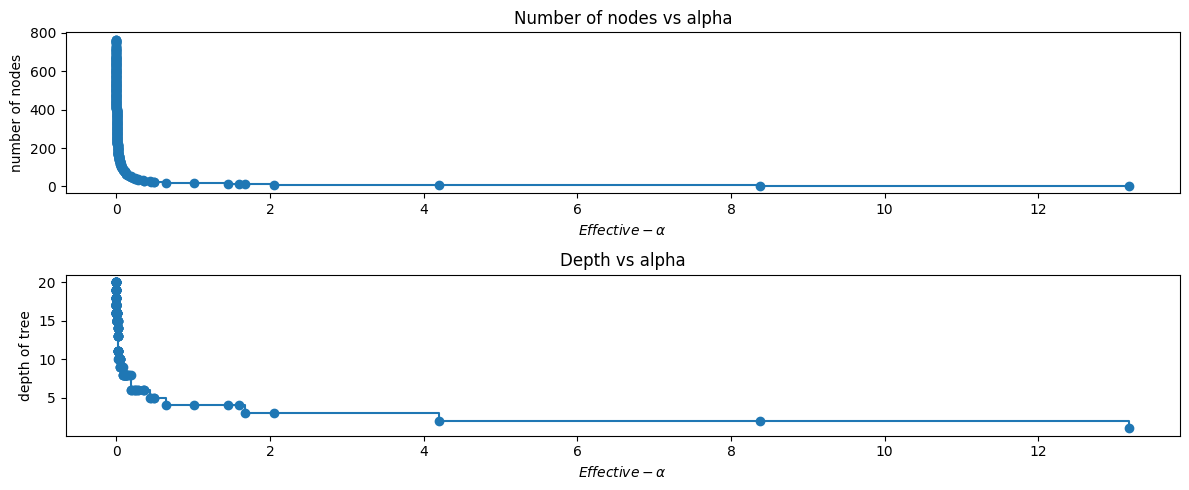

In [25]:
clfs = []
for alpha in ccp_alphas:
    regtree = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    regtree.fit(X_train, y_train)
    clfs.append(regtree)

node_counts = [clf.tree_.node_count for clf in clfs]
depths = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel(r'$Effective-\alpha$')
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depths, marker="o", drawstyle="steps-post")
ax[1].set_xlabel(r'$Effective-\alpha$')
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

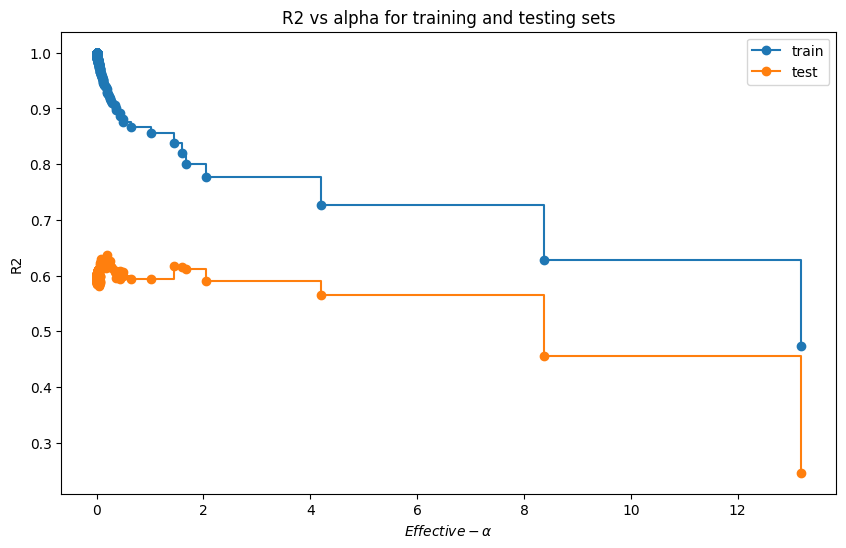

In [26]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel(r'$Effective-\alpha$')
ax.set_ylabel("R2")
ax.set_title("R2 vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
cv_data = pd.DataFrame({
      'alpha': ccp_alphas,
      'cv_mse': cv_mse,
      'cv_r2': cv_r2,
      'node_count': node_counts,
      'depth': depths,
      'train_score': train_scores,
      'test_score': test_scores
})
print(cv_data.head())
#pd.save_csv(cv_data, 'regtree_california_housing_cv_data.csv', index=False)

### Linear regression

In [27]:
from statsmodels.api import OLS

In [28]:
model = OLS(y_train, X_train).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   medv   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              797.2
Date:                Wed, 20 Aug 2025   Prob (F-statistic):                   4.85e-272
Time:                        20:31:33   Log-Likelihood:                         -1194.7
No. Observations:                 404   AIC:                                      2415.
Df Residuals:                     391   BIC:                                      2467.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------